# Dependencies

The `SimInterface` package depends on the `Scipy` stack. So nothing will work if you don't have that installed.

In order to see generate the block diagrams, you'll also need the `graphviz` package. 

# The DC Motor Example

In this notebook, we'll demonstrate how to use the SimInterface package to build a model of a DC motor connected with an RL circuit. 

The dynamic equations are given by:
\begin{align*}
L\dot I + RI &= V-K\dot\theta \\
J\ddot \theta + b\theta &= KI.
\end{align*}

Here, $V$ is an input voltage, $I$ is the current through the circuit, and $\theta$ is the angle of the motor. 

First, let's initialize the packages that we'll need. 

In [106]:
import SimInterface as SI
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integ
%matplotlib inline

# Defining Parameters

This system depends on the parameters, $L$, $R$, $K$, $J$, and $b$. To run a simulation with a fixed parameter set, their values could be hard-coded into the description of the differential equations. However, in many studies it is useful to be able to see how the system response to variations in the parameters. 

To facilitate this, we have a dedicated class for static variables called `Parameter`. To see how it works, we'll just initialize all of the parameters to some nominal values.

In [107]:
L = SI.Parameter(label='L',data=1.0)
R = SI.Parameter(label='R',data=2.0)
K = SI.Parameter(label='K',data=1.0)
J = SI.Parameter(label='J',data=.5)
b = SI.Parameter(label='b',data=.4)

Every parameter instance has a Pandas dataframe attribute `.data`:

In [108]:
L.data

,L
0,1


# Defining Signals

The voltage, $V$ is an exogenous input signal. We will take it to be a sinusoid of period $2$ and amplitude $3$, lasting for $10s$.

To define a `Signal`, we enter both the `data`, as well as time-stamps for the data. This is so that we know what time $V(t)$ takes a particular value.

In [109]:
Time = np.linspace(0,10,501)
Vsig = 3 * np.sin(np.pi * Time)
V = SI.Signal(label='V',data=Vsig,TimeStamp=Time)

Just like `Parameter` objects, the data for a `Signal` object is stored in a Pandas dataframe called `.data`. Let's look at the first 10 entries and also plot the data. 

In [110]:
V.data.iloc[:10]

,V
0.00,0.000000
0.02,0.188372
0.04,0.376000
0.06,0.562144
0.08,0.746070
0.10,0.927051
0.12,1.104374
0.14,1.277338
0.16,1.445261
0.18,1.607480


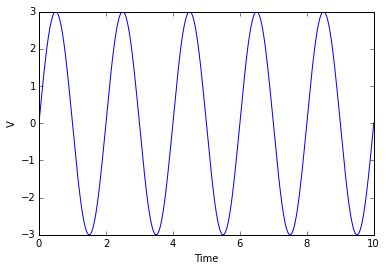

In [111]:
plt.plot(Time,V.data)
plt.xlabel('Time')
plt.ylabel(V.label)

# Defining the RL Circuit

The equations are sufficiently simple that we could code up one differential equation for all of them. However, it is instructive to code up the individual component systems separately, and then connect then connect them up later. 

For just the RL circuit, the dynamics of the current are given in first-order form as
\begin{equation*}
\dot I = -\frac{R}{L} I + \frac{1}{L}V_{diff},
\end{equation*}
where $V_{diff}$ is an auxilliary variable used in place of $V-K\theta$.

In code this is given by:

In [112]:
def RLVectorField(I,Vdiff,R,L):
    Idot = -(R/L) * I + (1./L) * Vdiff
    return Idot

We'll initialize $V_{diff}$ as $V$, as we'll assume for now that $\theta=0$. Later, we'll replace it with the true value of $V-K\theta$. 

In [113]:
Vdiff = SI.Signal(label='Vdiff',data=Vsig,TimeStamp=Time)

## Caution: Argument names should match variable labels.

It is important that in the function the arguments, `I`, `V`, `R`, and `L`, should match the labels given to associated signals and parameters. If they do not, the program will not know which data to associate with it.

## Initializing the current
We will assume that the initial current is given by $I(0) = 1$. We will store the current as a signal variable. At the moment, we only set the initial condition.

In [114]:
I = SI.Signal(label='I',data=1,TimeStamp=0.)
# Just display the signal to see that it worked.
I.data

,I
0,1


## Creating the differential equation system



We can create a differential equation system as follows.
Note that we must group the variables as state variables and input variables. Otherwise the system will not know what variables are exogenous and what are state variables.

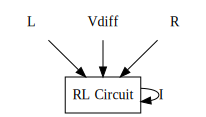

In [115]:
RLEquation = SI.DifferentialEquation(func=RLVectorField,StateVars=I,InputVars=(Vdiff,R,L),label='RL Circuit')
# If graphviz is installed a graph is automatically generated. It can be displayed as follows:
RLEquation.graph

## Simulating the RL Circuit

Defining the differential equation creates a method called `.VectorField`. This method is a function of the form $f(t,x)$, corresponding to the differential equation:
\begin{equation*}
\dot x = f(t,x)
\end{equation*}
Thus, the method can be used in conjunction with standard ODE integrators. 

In our particular example, $f$ corresponds to the vector field for the current, $I$. This state may have some auxilliary variables that are used for efficiently calculating input signals. Thus, it might have higher dimension than you expect.

Likewise, it also creates an initial state, vector, `.InitialState`. 

Let's see how to simulate this.

In [116]:
# This is a standard way to use the ODE class from scipy
Integrator = integ.ode(RLEquation.VectorField)
Integrator.set_integrator('dopri5').set_initial_value(RLEquation.InitialState,0.0)

X = np.zeros((len(Time),2))
for k in range(len(Time)):
    t = Time[k]
    x = Integrator.integrate(t)
    X[k] = x

## Putting the values into the Signal variables 

Simulating the differential equation defined by `RLEquation.VectorField` is a "read-only" operation in the sense that none of the signal variables, `I`, `Vdiff`, etc are updated in the process. Indeed, while $I$, the current was the desired state, the variable `I` data remains unchanged by the simulation process:

In [117]:
I.data

,I
0,1


We want the differential equations generated by `SimInterface` to behave just like those that would be coded "by hand". Thus, it is desirable that simulating the differential equation has no "side effects" that the user does not expect. One such side effect would be updating the data tables for the variables, such as `I`. 

In order to update the values we use the `.UpdateSignals` method. Once this is applied, the new data will be stored in `I`.

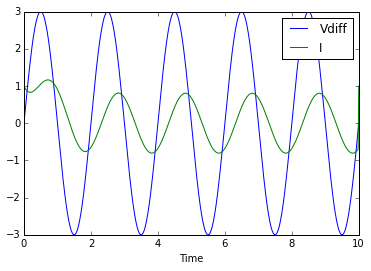

In [118]:
RLEquation.UpdateSignals(Time,X)
VH = plt.plot(Time,Vdiff.data,label=Vdiff.label)[0]
IH = plt.plot(Time,I.data,label=I.label)[0]
plt.xlabel('Time')
plt.legend(handles=(VH,IH))

# Defining the Motor

Recall the equation for the motor was given by:

\begin{equation*}
J \ddot \theta + b\dot\theta = KI.
\end{equation*}

This equation is of second-order. We can put it into first-order form by setting $\omega = \dot\theta$:
\begin{align*}
\dot\theta &= \omega \\
\dot\omega &= -\frac{b}{J}\omega + \frac{K}{J} I.
\end{align*}

In code, we can define this as:

In [119]:
def MotorVectorField(theta,omega,I,J,b,K):
    theta_dot = omega
    omega_dot = -(b/J) * omega + (K/J) * I
    return theta_dot, omega_dot

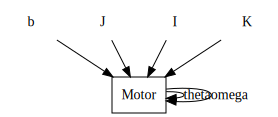

In [120]:
theta = SI.Signal(label='theta',data=0.,TimeStamp=0)
omega = SI.Signal(label='omega',data=0.,TimeStamp=0)
MotorEquation = SI.DifferentialEquation(func=MotorVectorField,StateVars=(theta,omega),InputVars=(I,J,b,K),
                                        label='Motor')
MotorEquation.graph

In [121]:
def VdiffFunc(V,omega,K):
    Vdiff = V - K * omega
    return Vdiff

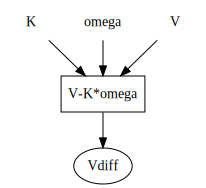

In [122]:
VdiffSys = SI.StaticFunction(func=VdiffFunc,InputVars=(V,omega,K),OutputVars=Vdiff,label='V-K*omega')
VdiffSys.graph

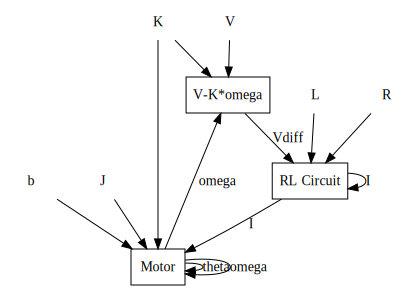

In [123]:
Sys = SI.Connect((MotorEquation,RLEquation,VdiffSys))
Sys.graph

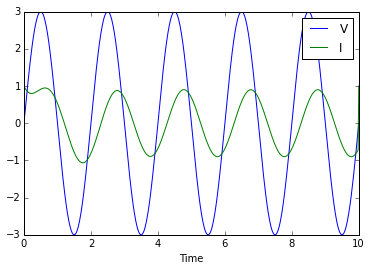

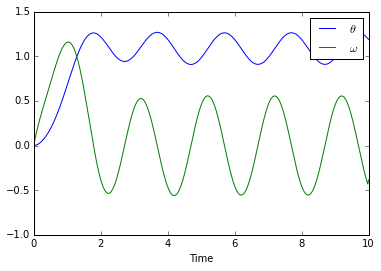

In [124]:
Integrator = integ.ode(Sys.VectorField)
Integrator.set_integrator('dopri5').set_initial_value(Sys.InitialState,0.0)

X = np.zeros((len(Time),len(Sys.InitialState)))
for k in range(len(Time)):
    t = Time[k]
    x = Integrator.integrate(t)
    X[k] = x
    
Sys.UpdateSignals(Time,X)

plt.figure()
hV = plt.plot(Time,V.data,label='V')[0]
hI = plt.plot(Time,I.data,label='I')[0]
plt.legend(handles=(hV,hI))
plt.xlabel('Time')

plt.figure()
hTheta = plt.plot(Time,theta.data,label=R'$\theta$')[0]
hOmega = plt.plot(Time,omega.data,label='$\omega$')[0]
plt.legend(handles=(hTheta,hOmega))
plt.xlabel('Time')

In [125]:
omega.data

,omega
0.00,0.000000
0.02,0.038916
0.04,0.075805
0.06,0.110872
0.08,0.144312
0.10,0.176309
0.12,0.207038
0.14,0.236663
0.16,0.265337
0.18,0.293202
